In [19]:
import io
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import numpy as np

In [2]:
plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [3]:
plt.ion()
plt.style.use('seaborn-colorblind')

In [4]:
conn = sqlite3.connect('sql/sql.db')
cursor = conn.cursor()

In [5]:
#Executar só uma vez a cada vez que abrir o colab
f = io.open('sql/trabalho.sql', 'r', encoding='ISO-8859-1')
sql = f.read()
cursor.executescript(sql)

OperationalError: table ANSWERS already exists

Modelo relacional
<img src="diagrama/diagrama.png">

# Questão 2: Existe uma relação entre o aumento do IDH do país e a maior sensação de segurança?

In [6]:
query = """
Select COUNTRYCODE,SUBSET,PERCENTAGE,VALOR,HDI,VALUE
From PESOS NATURAL JOIN ANSWERS NATURAL JOIN SIZE NATURAL JOIN IDH
WHERE SUBSET == TIPO

"""

df = pd.read_sql_query(query,conn)
df["TAMANHO"] = df["PERCENTAGE"] * df["VALOR"] * 0.01
df

,COUNTRYCODE,SUBSET,PERCENTAGE,VALOR,HDI,VALUE,TAMANHO
0,0,LESBIAN,33,437,885.0,0.0,144.21
1,0,LESBIAN,53,437,885.0,1.0,231.61
2,0,LESBIAN,2,437,885.0,0.5,8.74
3,0,GAY,51,1558,885.0,0.0,794.58
4,0,GAY,25,1558,885.0,1.0,389.50
...,...,...,...,...,...,...,...
4703,11,BIM,65,294,907.0,0.0,191.10
4704,11,BIM,3,294,907.0,0.5,8.82
4705,11,TRANS,31,813,907.0,1.0,252.03
4706,11,TRANS,65,813,907.0,0.0,528.45


In [7]:
def boostreap(p,n_size = 500):
    values = np.zeros(n_size)
    
    d = pd.DataFrame(p)
    
    for i in range(n_size):
        sample = d[0].sample(replace = True,n = len(p))
        values[i] = sample.mean()
        
    return values

In [8]:
indx = list(df.groupby("COUNTRYCODE").mean().sort_values("HDI").index)
meio = int(len(indx)/2)

maus = indx[:meio]
bons = indx[meio:]

In [9]:
def gerarB(selecionados,df,n_size=500):
    p = []
    for country in selecionados:
        pais = df[df["COUNTRYCODE"] == country]

        for x in range(pais.shape[0]):
            sample = pais.iloc[x]
            for _ in range(int(sample["TAMANHO"])):
                p.append(sample["VALUE"])

    b = boostreap(p,n_size=n_size)
    
    return b

In [10]:
bonsB = gerarB(bons,df)
mausB = gerarB(maus,df)

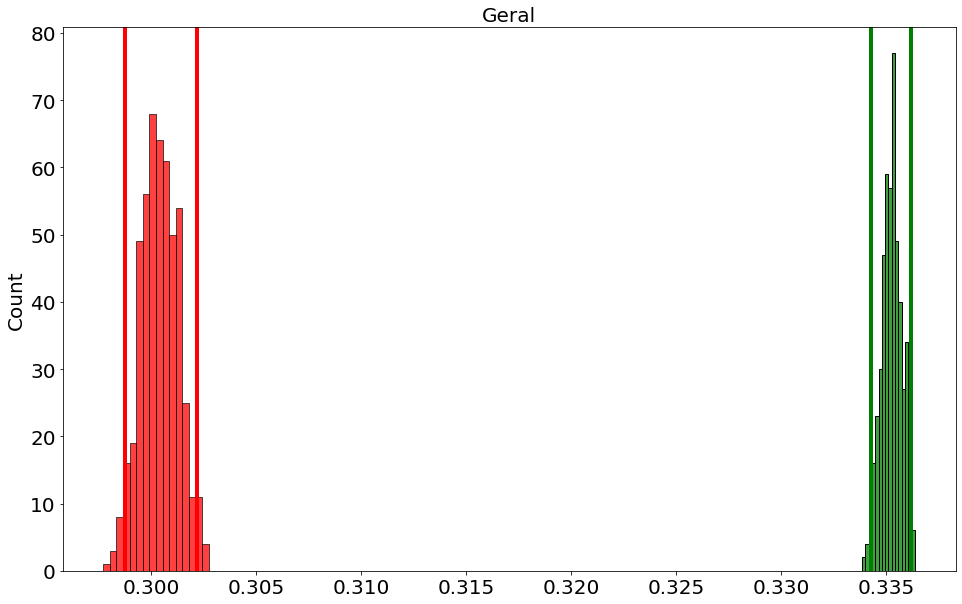

In [11]:
sns.histplot(bonsB,color="g")
inf = np.percentile(bonsB,2.5)
sup = np.percentile(bonsB,97.5)
plt.axvline(inf,color="g")
plt.axvline(sup,color="g")

sns.histplot(mausB,color="r")
inf = np.percentile(mausB,2.5)
sup = np.percentile(mausB,97.5)
plt.axvline(inf,color="r")
plt.axvline(sup,color="r")

plt.title("Geral")

plt.show()

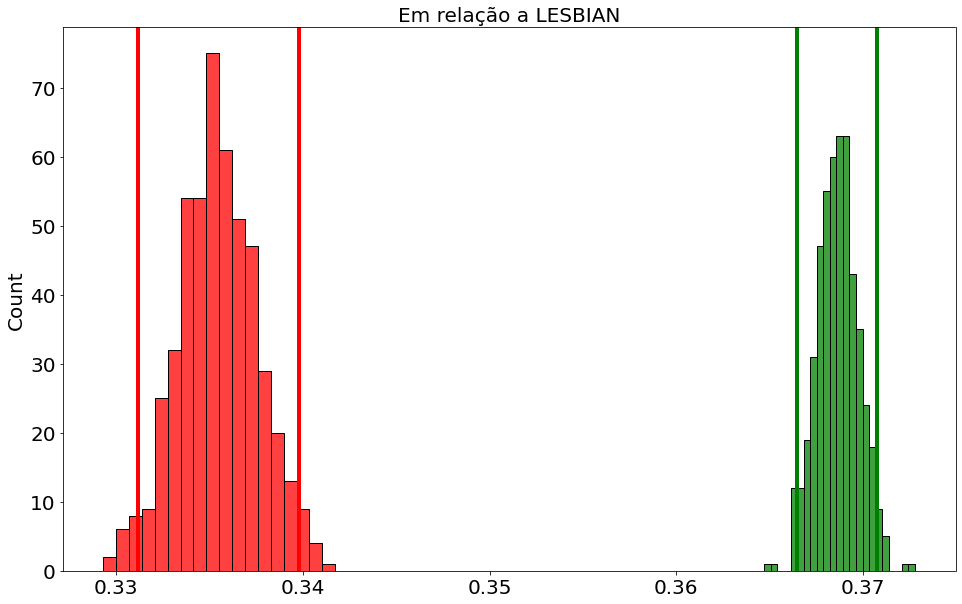

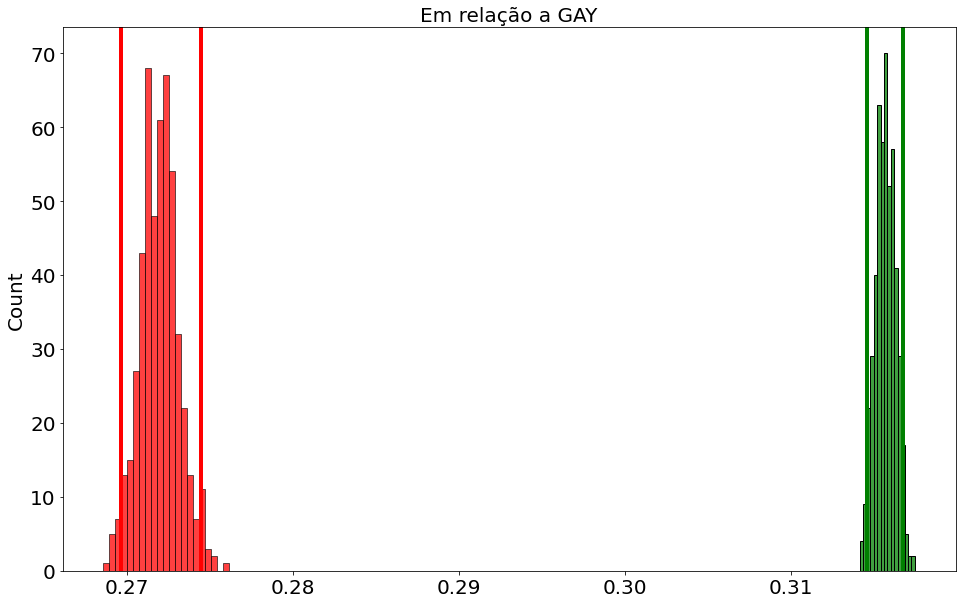

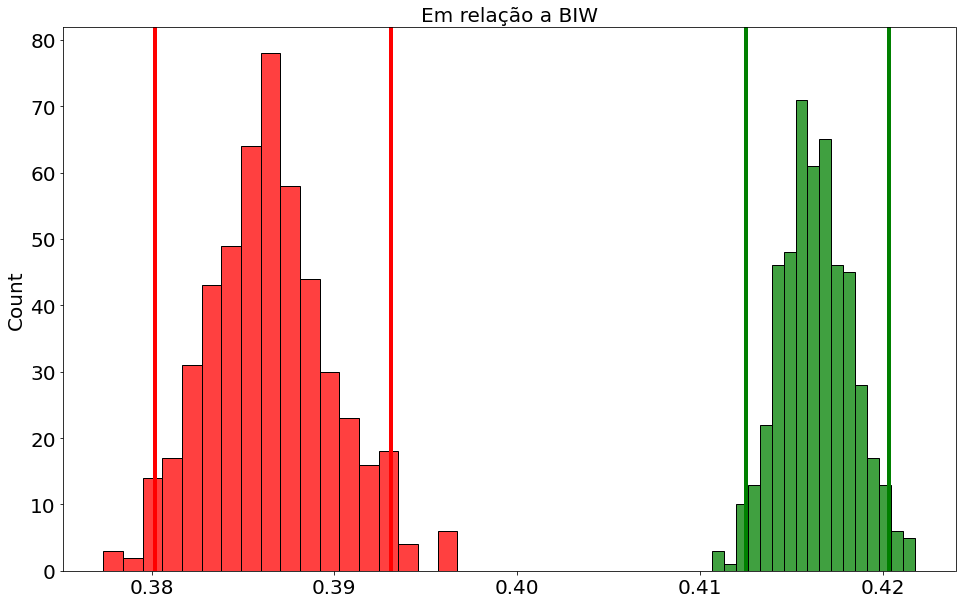

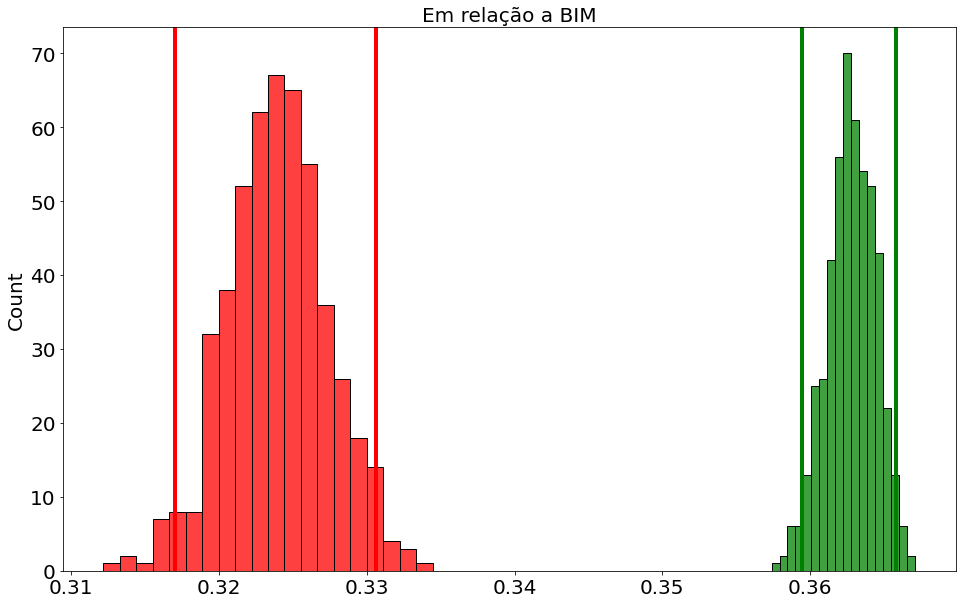

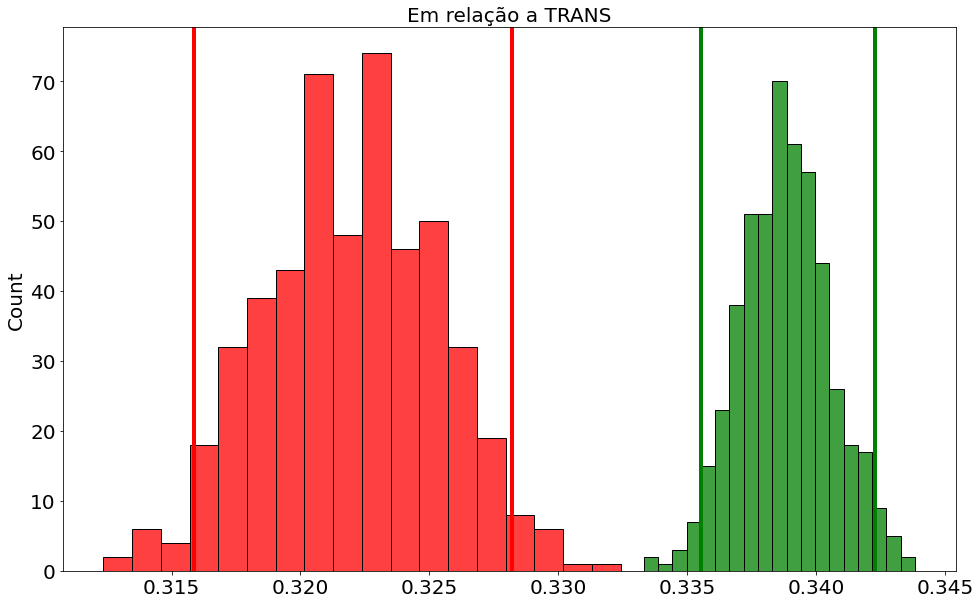

In [15]:
for x in df["SUBSET"].unique():
    df2 = df[df["SUBSET"] == x]
    
    bonsB = gerarB(bons,df2)
    mausB = gerarB(maus,df2)
    
    sns.histplot(bonsB,color="g")
    inf = np.percentile(bonsB,2.5)
    sup = np.percentile(bonsB,97.5)
    plt.axvline(inf,color="g")
    plt.axvline(sup,color="g")

    sns.histplot(mausB,color="r")
    inf = np.percentile(mausB,2.5)
    sup = np.percentile(mausB,97.5)
    plt.axvline(inf,color="r")
    plt.axvline(sup,color="r")
    
    #plt.xlim(0.2,0.5)
    
    plt.title("Em relação a {}".format(x))

    plt.show()

In [13]:
conn.close()
f.close()